In [4]:
## imports
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from scipy.signal import argrelextrema
from math import pi, sqrt
import qnm

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [5]:
## Data reading functions

def GetWaveformRadius(rad):
    psi4_file = bev_dir() + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, radius=-1, mode=(2,2)): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode=(2,2)): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def hPsi4Factor(hPsi4):
    B = 0.1 ## The scale factor we multiply by
    """ h^{(2)}_{ab} -> need to divide by B^2, since the metric comes in at alpha^2, 
        and anywhere we have seen an alpha, we have put a B """
    hPsi4 = hPsi4 / B**2
    return hPsi4

def GethPsi4Mode(p, radius=-1, mode=(2,2)): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rDeltaPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    hPsi4 = re + 1j*im
    return time, hPsi4Factor(hPsi4)

def GethPsi4ModeExtrapolated(p, mode=(2,2)): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMDeltaPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    hPsi4 = re + 1j*im
    return time, hPsi4Factor(hPsi4)


In [6]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

1270.9129269829396 130.4294090963965
1270.9026803551249 105.51914847598619
1270.9343978101358 80.75083521465422
1270.8720349865646 56.58818046596548
1270.9156112032588 35.230636473676896


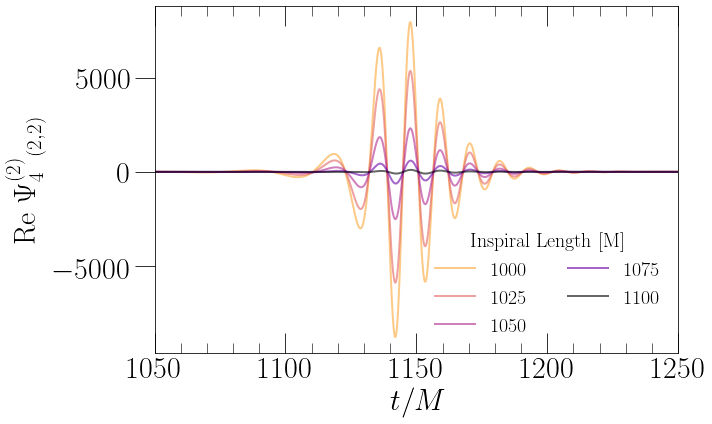

In [25]:
## Secular growth plots
def SecularRegimePlot(): 
    
    
    start_arr = [1000, 1025, 1050, 1075, 1100]
    ramp = 25
    figname = 'SecularhPsi4'
    figsize=(10,6)
        
    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/len(start_arr)) for i in range(len(start_arr))][::-1]
        
    f, ax = plt.subplots(1, figsize=figsize)
    
    for start, color in zip(start_arr, colors):
        
        ## Get the extrapolated waveforms
        p = "/Users/mokounkova/EDGB/NonSpinning/Data/" + str(start) + "/BBH_SKS_d10.8_q1_sA_0_0_0_sB_0_0_0/Lev0/"
        time, data = GethPsi4ModeExtrapolated(p)
        
        ## Let's calculate the length until the merger time
        t_peak = GetPeakTimeMode(time, data)
        length = t_peak - start - ramp/2.0
        print(time[-1], length)
        
        #time = SubtractPeakTimeMode(time, data)
        #time, data = CutTimes(time, data, 1000, 1300)

        lw = 2.0
        ls='-'
        if start == start_arr[-1]:
            color = 'black'
            lw = 2.0
            ls='--'
        ax.plot(time, data, color = color, label="%d" % start, lw=lw, alpha=0.6)
    
    legend = ax.legend(fontsize=20, loc='best', frameon=False, ncol=2, \
              title='Inspiral Length [M]')
    plt.setp(legend.get_title(),fontsize=20)
    ax.set_ylabel('Re $\Psi_4^{(2)} {}_{(2,2)}$', fontsize=30)
    ax.set_xlim(1050, 1250)
    #ax.set_yscale('log')
    #ax.set_ylim(1e-10, 1e4)
        
    ax.set_xlabel('$t/M$', fontsize=30) 
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

SecularRegimePlot()

In [ ]:
## Plot around t_s = 2100
def LIGOBucketPlot(): 
    
    
    figname = 'LIGOBuckethPsi4'
    start_arr = [2350, 2425, 2450, 2475, 2500]
    ramp_arr = [100, 25, 25, 25, 25]
    
    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/3) for i in range(3)][::-1]
        
    f, ax = plt.subplots(1, figsize=(12,9))
    
    def GrabData(start, ramp, lev=0):
        #time, data = GethPsi4Mode(ev_dir(start, lev=lev, ramp_time=ramp), radius=0)
        time, data = GethPsi4ModeExtrapolated(ex_dir(start, ramp, lev=lev))
        time = SubtractPeakTimeMode(time, data)
        
        #time, data = CutTimes(time, data, -150, 150)  
        return time, data

    #time, data = GrabData(2050, lev=0)
    #ax.plot(time, data, color = 'blue', label='Earlier start, Low', lw=1.0, ls='--',alpha=0.5)
 
    ## Plot 2100 line and errors
    for lev, lab, color in zip([0], ['Low', 'Med', 'High'], colors):
        time, data = GrabData(2500, 25, lev=lev)
        ax.plot(time, data, alpha=1.0, label=lab,lw=1.0,color=color)

    time, data = GrabData(2475, 25, lev=0)
    ax.plot(time, data, color = 'blue', lw=1.0, alpha=1.0, ls='--',label='Earlier start')

    #time, data = GrabData(2000, lev=0)
    #ax.plot(time, data, color = 'blue', lw=0.5, alpha=1.0, ls='--',label='Earlier start')

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1, title='Resolution')
    for legobj in legend.legendHandles:
        legobj.set_linewidth(2.0)
    plt.setp(legend.get_title(),fontsize=26)
    ax.set_ylabel('Re ' + LabelsDict[GethPsi4ModeExtrapolated] + str(mode), fontsize=30)
    #ax.set_xlim(-80, 80)

    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()      

LIGOBucketPlot()


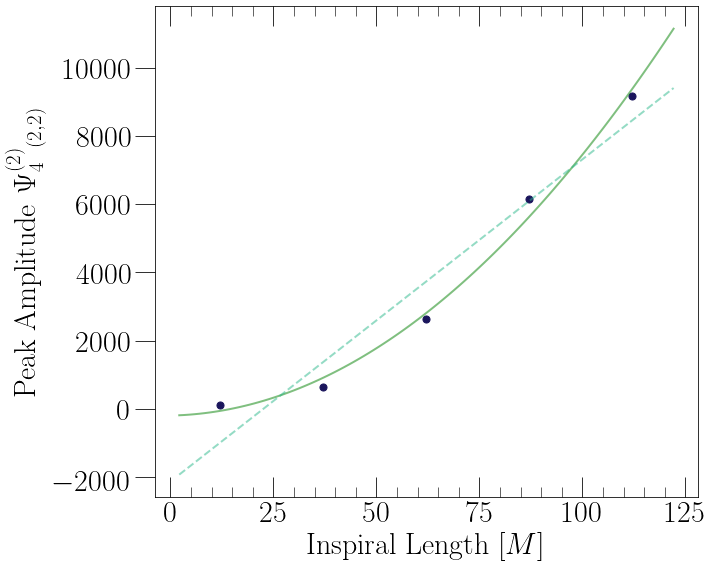

In [29]:
## Peak amplitude plot
def PeakAmplitudesPlot(): 
    
    t_merger = 1124.64 ## for this simulation
    ramp = 25
    
    ## All runs
    start_arr = [1000, 1025, 1050, 1075, 1100]
    figname = 'PeakAmplitude'
    figsize=(10,8)

    f, ax = plt.subplots(1, figsize=figsize)
    
    peak_amplitudes = []
    lengths = []
    
    def GetData(start):
        
        p = "/Users/mokounkova/EDGB/NonSpinning/Data/" + str(start) + "/Ev/JoinedLev0/"
        
        ## Get the extrapolated waveforms
        time, data = GethPsi4Mode(p, radius=0)

        time = SubtractPeakTimeMode(time, data)
        time, data = CutTimes(time, data, -100, 100)
        
        """Run length should be

        t_peak - t_start - t_ramp/2.0

        Since we have a ramped-on portion with area
        (tp - (ts + tr))
        but then a ramp on portion with area tr/2.0 """
        
        length = t_merger - start - ramp/2.0 ## minus ramp time
        peak_amplitude = np.max(np.abs(data))
        
        return length, peak_amplitude
        
    for start in start_arr:
        
        length, peak_amplitude = GetData(start)
        lengths.append(length)
        peak_amplitudes.append(peak_amplitude)
        
    ## Fit a quadratic
    lengths = lengths[::-1]
    peak_amplitudes = peak_amplitudes[::-1]
    peak_amplitudes = peak_amplitudes[-5:]
    fit_lengths = np.linspace(lengths[0] - 10, lengths[-1] + 10, 100)
    
    z = np.polyfit(lengths, peak_amplitudes, 2)
    p = np.poly1d(z)
    plt.plot(fit_lengths, p(fit_lengths), ls='-', color='green',label='Quadratic fit',alpha=0.5, lw=2.0)
    
    z = np.polyfit(lengths, peak_amplitudes, 1)
    p = np.poly1d(z)
    plt.plot(fit_lengths, p(fit_lengths), ls='--', color='#2ab88b',label='Linear fit',alpha=0.5, lw=2.0)
    
    plt.scatter(lengths, peak_amplitudes, marker='.', s=200, color='#1a155c')
    
    #plt.axvline(lengths[0], color='black', ls='-.', lw=1.0)
    ax.set_xlabel('Inspiral Length $[M]$', fontsize=30)
    ax.set_ylabel('Peak Amplitude $\Psi_4^{(2)} {}_{(2,2)}$', fontsize=30)
    #plt.xlim(fit_lengths[0], fit_lengths[-1])
    #plt.legend(frameon=False, fontsize=25)
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

PeakAmplitudesPlot()

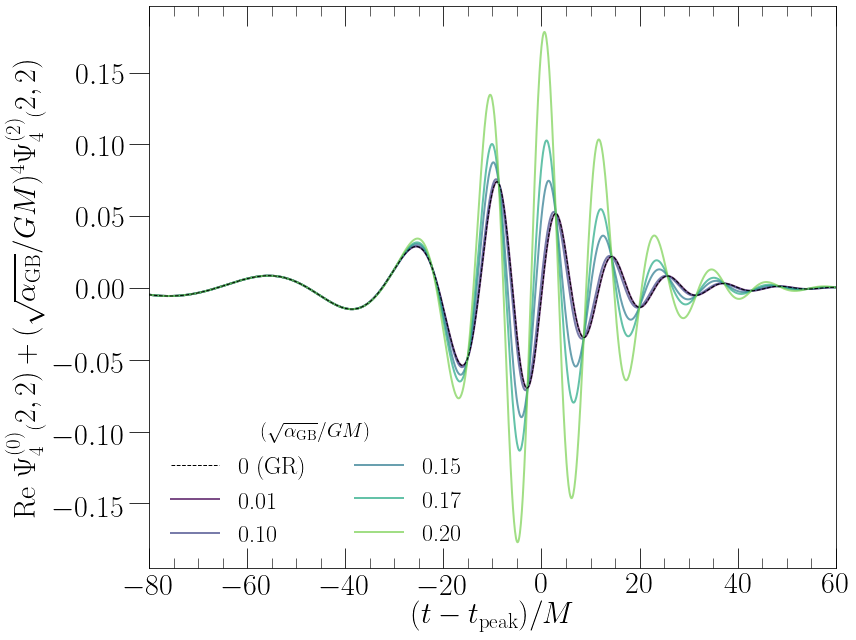

In [37]:
## GR and EDGB together

def TogetherPlot(log=False): 
    color_map='viridis'
    figname = 'Together_log' if log else 'Together'
    
    lev = 0
        
    rad = 10
    f, ax = plt.subplots(1, figsize=(12,6) if log else (12, 9))
    
    
    start = 1100
    p = "/Users/mokounkova/EDGB/NonSpinning/Data/" + str(start) + "/Ev/JoinedLev0/"
    
    time, data = GethPsi4Mode(p, radius=rad)
    #time, data = GethPsi4ModeExtrapolated(ex_dir(2500, 25, lev=lev))
    t_peak = GetPeakTimeModeReal(time, data)
    time = time - t_peak
    ## Cut the time with the ramp time because that wasn't done
    cut_min = min(time) - 25
    cut_max = max(time)
    time, data = CutTimes(time, data, cut_min, cut_max)  
    
    gr_time, gr_data = GetPsi4Mode(p, radius=rad)
    #gr_time, gr_data = GetPsi4ModeExtrapolated(bex_dir(lev=lev))
    gr_time = gr_time - t_peak
    gr_time, gr_data = CutTimes(gr_time, gr_data, cut_min, cut_max)

    ## Now get gr on the same axis
    gr_data = InterpolateTimes(gr_time, gr_data, time)
    gr_time = time
    
    #ax.plot(time, data)
      
    l_arr = [0.01, 0.1, 0.15, 0.17, 0.2] 
    
    cmap = matplotlib.cm.get_cmap(color_map)
    colors = [cmap(float(i)/(len(l_arr))) for i in range(len(l_arr))]
    ax.plot([0,0], [0, 0], lw=1.0, ls='--', color='black',label='0 (GR)') ## for the laebl
    
    
    for l, color in zip(l_arr, colors):
        total = gr_data + l**4 * data
        ax.plot(time, total, lw=2.0, label='%.2f' % l, color=color,alpha=0.7)
    ax.plot(time, gr_data, lw=1.0, ls='--', color='black')
       

    legend = ax.legend(fontsize=24, loc='lower left', frameon=False, ncol=2, \
                       title=r'$(\sqrt{\alpha_\mathrm{GB}}/GM)$')
    plt.setp(legend.get_title(),fontsize=20)
    ax.set_ylabel(r'Re $\Psi_4^{(0)} {}_(2,2) + (\sqrt{\alpha_\mathrm{GB}}/GM)^4 \Psi_4^{(2)} {}_(2,2)$' , \
                  fontsize=30)
    if log:
       ax.set_ylabel(r'$\|\textrm{Re }\Psi_4^{(0)} {}_(2,2) + (\sqrt{\alpha_\mathrm{GB}}/GM)^4 \Psi_4^{(2)} {}_(2,2)\|$' \
                     , fontsize=26)
    ax.set_xlim(-50, 50)
    ax.set_xlim(cut_min, cut_max)
    if log:
        ax.set_ylim(3e-3, 1e-1)
        ax.set_xlim(-80, 20)
    else:
        ax.set_xlim(-80, 60)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    if log:
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

TogetherPlot()
#TogetherPlot(log=True)


/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


1000 0.05734628441926224
1025 0.06337605282333612
1050 0.078439984488386
1075 0.11071121324966328
1100 0.15960168586416518


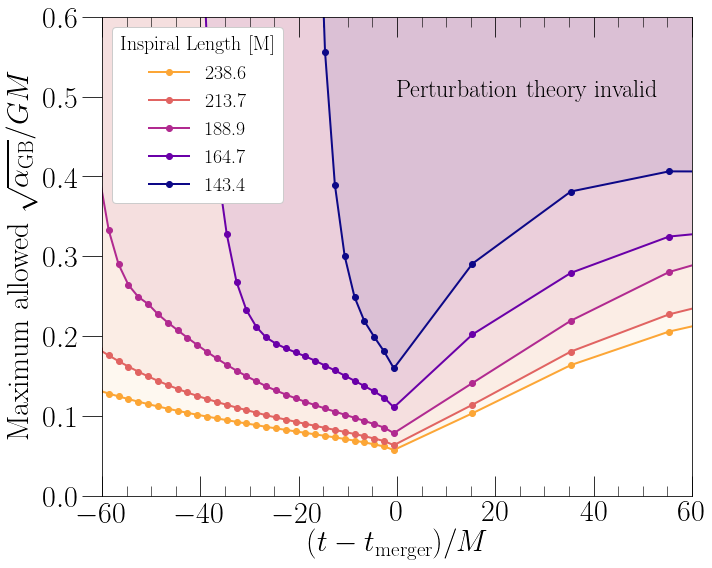

In [17]:
## Regime of validity

def ComputeEpsilon(p):
    
    t_merger = 1124.64 ## for this simulation
    
    filename = p + 'Validity.dat'
    Time = []
    Validity = []
    C4 = 0.1**(1.0/4.0) ## fourth root of the tolerance factor, from the previous notebook
    
    for line in open(filename):
        li=line.strip()
        if not li.startswith("#"):
            A = li.split()
            a = np.array(A).astype(np.float)
            Time.append(a[0])
            if a[0] > t_merger:
                Val = sorted(a[1:])[::-1][1]
            else:
                Val = sorted(a[1:])[::-1][2]
            ## Correct for the B factor -- in the code we make delta psi articificially small by
            ## multiplying it by B < 1, so here we need to divide by this B to make it big again
            ## recall Val is like delta psi / psi 
            B = 0.1 
            #print(Val)
            Val = Val / B 
            Validity.append(Val)

    Time = np.array(Time)
    Time = Time - t_merger
    ## Validity is the pointwise \Delta g / g
    ## so we need 
    
    ## Apply the transformation
    ## We want the minimum, which is 1/ the maximum
    ## Assume that the only thing we're doing to the metric is a factor of alpha and beta
    ## Right now going to do sqrt(alpha)/GM as our measure
    Epsilon = C4  * (np.divide(1.0, Validity))**(1.0/4.0)
    #print(Epsilon)
 
    return Time, Epsilon 


def PlotValidity(figname):  
    
    figname = 'Validity'
    
    start_arr = ['1000', '1025', '1050','1075','1100']
    
    ramp = 25
    
    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/len(start_arr)) for i in range(len(start_arr))][::-1]
        
    f, ax = plt.subplots(1, figsize=(10,8))
    
    for start, color in zip(start_arr, colors):
        
        p = "/Users/mokounkova/EDGB/NonSpinning/Data/" + str(start) + "/Ev/JoinedLev0/"
        time, data = GethPsi4Mode(p, radius=0)
        ## Let's calculate the length until the merger time
        t_peak = GetPeakTimeMode(time, data)
        length = t_peak - float(start) - float(ramp)/2.0
        time, eps = ComputeEpsilon(p)
        # Cut the time so only considering dCS effects
        #time, eps = CutTimes(time, eps, -400, 200)
        print (start, min(eps))
        ind = np.where(eps < 1e3)
        time = time[ind]
        eps = eps[ind]
        #time = time[1:]
        #eps = eps[1:]
        ax.plot(time, eps, '-o', color = color, label='%.1f' % length, lw=2.0)
        
        ax.fill_between(time, eps, 2.0, color=color,alpha=0.07)

        
    legend = ax.legend(fontsize=20, loc='upper left', frameon=True, framealpha = 1.0, ncol=1, \
                       title='Inspiral Length [M]')
    plt.setp(legend.get_title(),fontsize=20)
    #ax.set_yscale('log')
    ax.text(0, 0.5, 'Perturbation theory invalid', fontsize=24, color='black')
    ax.set_xlabel('$(t - t_\mathrm{merger})/M$', fontsize=30) 
    ax.set_ylabel(r'Maximum  allowed $\sqrt{\alpha_\mathrm{GB}}/GM$', fontsize=30)
    ax.set_xlim(-60, 60)
    ax.set_ylim(0.0, 0.6)
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

    
PlotValidity('Validity.pdf')
